In [1]:
from pathlib import Path
from artifactremoval.modelarch import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
base_dir = Path.cwd().parent
input_dir = base_dir / "data" / "ratings" / "aggregate_data"
test_data = load_most_recent_pickle(input_dir, prefix="spectral_test_")
train_data = load_most_recent_pickle(input_dir, prefix="spectral_train_")
output_dir = base_dir / "results"


# Load saved data
with open(output_dir / "ensemble_metrics_data.pkl", "rb") as f:
    metrics_data = pickle.load(f)

# Order of experiments for consistent plotting/table
exp_order = [
    'baseline_raw', 'fit1_only', 'fit2_only', 'fits_combined', 'raw+fits', 
    'raw+water', 'fits+water', 'all_four',
]

label_map = {
    'baseline_raw':  'Raw',
    'raw+water':     'Raw + Water',
    'raw+fits':      'Raw + Fits',
    'all_four':      'All 4',
    'fits+water':    'Water + Fits',
    'fit1_only':     'MIDAS Fit',
    'fit2_only':     'NNFit',
    'fits_combined': 'Fits Only'
}

# Fit label encoder on training labels
train_labels = [
    e["consensus_rating"] for e in train_data if e.get("consensus_rating") is not None
]
le = LabelEncoder().fit(train_labels)

# Preprocess test set
raw_te, wat_te, f1_te, f2_te, y_te, _ = preprocess(test_data, label_encoder=le)

Loading most recent file: spectral_test_20250423_1640.pkl
Loading most recent file: spectral_train_20250423_1640.pkl


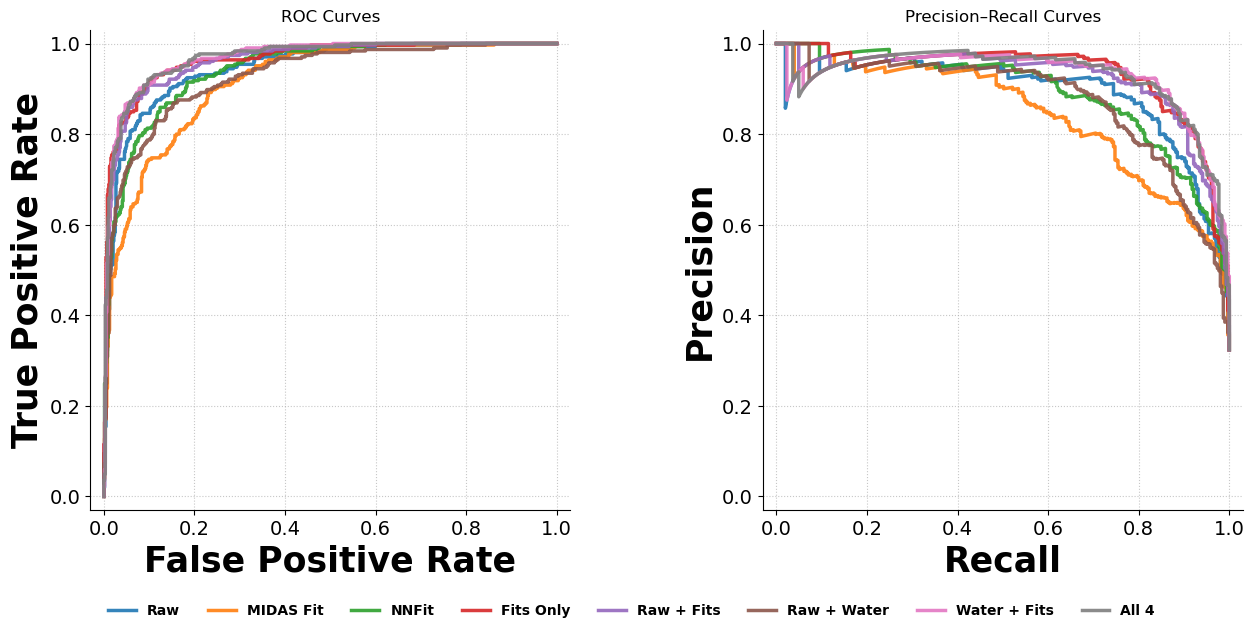

In [4]:
import matplotlib.patheffects as pe

fig, (ax_roc, ax_pr) = plt.subplots(
    1, 2, figsize=(14, 6),
)

# define a few different line‐styles and markers
styles  = ['-', '--', '-.', ':']



# reset color cycle if you want a fresh palette
ax_pr.set_prop_cycle(plt.cycler('color', plt.get_cmap('tab10').colors))

# ROC curves with white halos
for  key in exp_order:
    d = metrics_data[key]
    ax_roc.plot(
        d["fpr"], d["tpr"],
        linewidth=2.5, alpha=0.9,
        label=label_map[key],
        #path_effects=[
        #    pe.Stroke(linewidth=6, foreground='white'),
        #    pe.Normal()
        #]
    )

# PR curves with white halos
for key in exp_order:
    d = metrics_data[key]
    precision, recall, _ = precision_recall_curve(y_te, d["y_prob"])
    ax_pr.plot(
        recall, precision,
        linewidth=2.5, alpha=0.9,
        label=label_map[key],
       #path_effects=[
       #     pe.Stroke(linewidth=6, foreground='white'),
       #     pe.Normal()
       # ]
    )
# padding amount (2% of the unit square)
pad = 0.03

for ax in (ax_roc, ax_pr):
    # pad the limits slightly beyond [0,1]
    ax.set_xlim(-pad, 1 + pad)
    ax.set_ylim(-pad, 1 + pad)
    ax.set_aspect("equal", "box")
    ax.grid(linestyle=":", alpha=0.7)

    # bigger, bold text
    ax.title.set_fontsize(18);  ax.title.set_fontweight("bold")
    ax.xaxis.label.set_fontsize(25); ax.xaxis.label.set_fontweight("bold")
    ax.yaxis.label.set_fontsize(25); ax.yaxis.label.set_fontweight("bold")
    ax.tick_params(axis="both", labelsize=14)

    # remove only the top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# labels & legends
ax_roc.set_title("ROC Curves")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_pr.set_title("Precision–Recall Curves")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")

# 1) shrink the axes area to make room at the bottom
fig.subplots_adjust(bottom=0.20)   # increase bottom margin

handles, labels = ax_roc.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(exp_order),
    frameon=False,
    fontsize=25,
    bbox_to_anchor=(0.45, -0.1),
    prop={'weight': 'bold'}
)
# tighten everything up
fig.subplots_adjust(left=0.05, right=0.90, top=0.90, bottom=0.10, wspace=0.3)

plt.show()


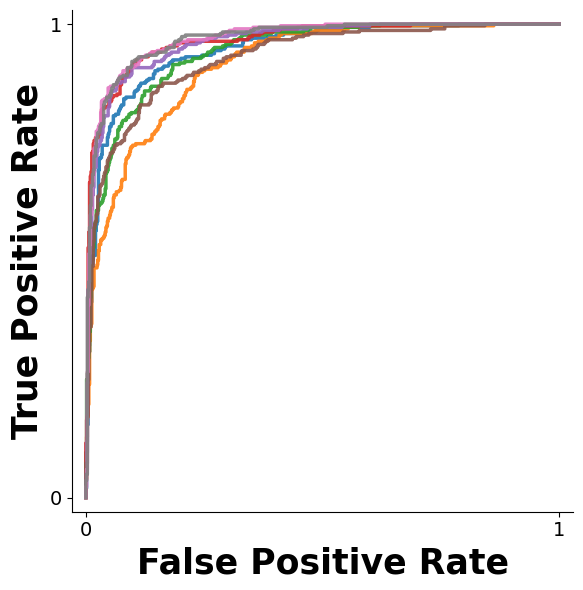

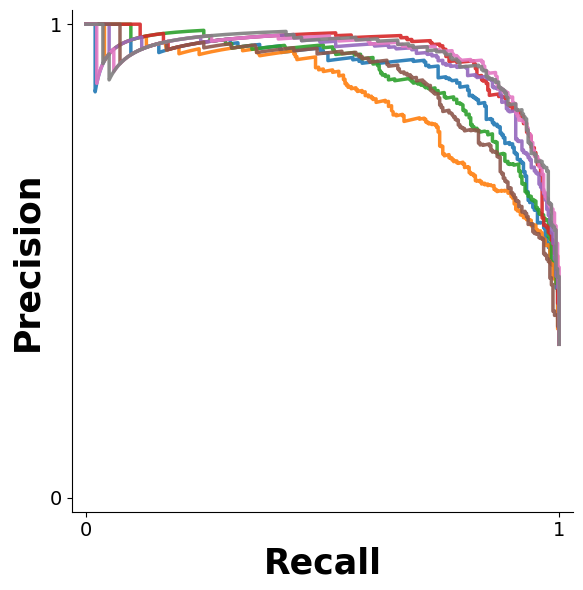

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from sklearn.metrics import precision_recall_curve

# padding amount (2% of the unit square)
pad = 0.03

# --- ROC figure ----------------------------------------------------------
fig_roc, ax_roc = plt.subplots(figsize=(7, 6))

# ROC curves
for key in exp_order:
    d = metrics_data[key]
    ax_roc.plot(
        d["fpr"], d["tpr"],
        linewidth=2.5, alpha=0.9
    )

# Styling
ax_roc.set_xlim(-pad, 1 + pad)
ax_roc.set_ylim(-pad, 1 + pad)
ax_roc.set_aspect("equal", "box")
ax_roc.grid(linestyle=":", alpha=0.7)
ax_roc.title.set_fontsize(18);  ax_roc.title.set_fontweight("bold")
ax_roc.xaxis.label.set_fontsize(25); ax_roc.xaxis.label.set_fontweight("bold")
ax_roc.yaxis.label.set_fontsize(25); ax_roc.yaxis.label.set_fontweight("bold")
ax_roc.tick_params(axis="both", labelsize=14)
ax_roc.spines["top"].set_visible(False)
ax_roc.spines["right"].set_visible(False)

# Labels (no legend)
#ax_roc.set_title("ROC Curves")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")

# only show tick labels at 0 and 1
ax_roc.set_xticks([0, 1])
ax_roc.set_yticks([0, 1])
ax_roc.grid(False)          # turn off grid


plt.tight_layout()
plt.show()


# --- PR figure -----------------------------------------------------------
fig_pr, ax_pr = plt.subplots(figsize=(7, 6))

# reset color cycle
ax_pr.set_prop_cycle(plt.cycler('color', plt.get_cmap('tab10').colors))

# PR curves
for key in exp_order:
    d = metrics_data[key]
    precision, recall, _ = precision_recall_curve(y_te, d["y_prob"])
    ax_pr.plot(
        recall, precision,
        linewidth=2.5, alpha=0.9
    )

# Styling
ax_pr.set_xlim(-pad, 1 + pad)
ax_pr.set_ylim(-pad, 1 + pad)
ax_pr.set_aspect("equal", "box")
ax_pr.grid(linestyle=":", alpha=0.7)
ax_pr.title.set_fontsize(18);  ax_pr.title.set_fontweight("bold")
ax_pr.xaxis.label.set_fontsize(25); ax_pr.xaxis.label.set_fontweight("bold")
ax_pr.yaxis.label.set_fontsize(25); ax_pr.yaxis.label.set_fontweight("bold")
ax_pr.tick_params(axis="both", labelsize=14)
ax_pr.spines["top"].set_visible(False)
ax_pr.spines["right"].set_visible(False)

# Labels (no legend)
#ax_pr.set_title("Precision–Recall Curves")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")


# only show tick labels at 0 and 1
ax_pr.set_xticks([0, 1])
ax_pr.set_yticks([0, 1])
ax_pr.grid(False)          # turn off grid

plt.tight_layout()
plt.show()


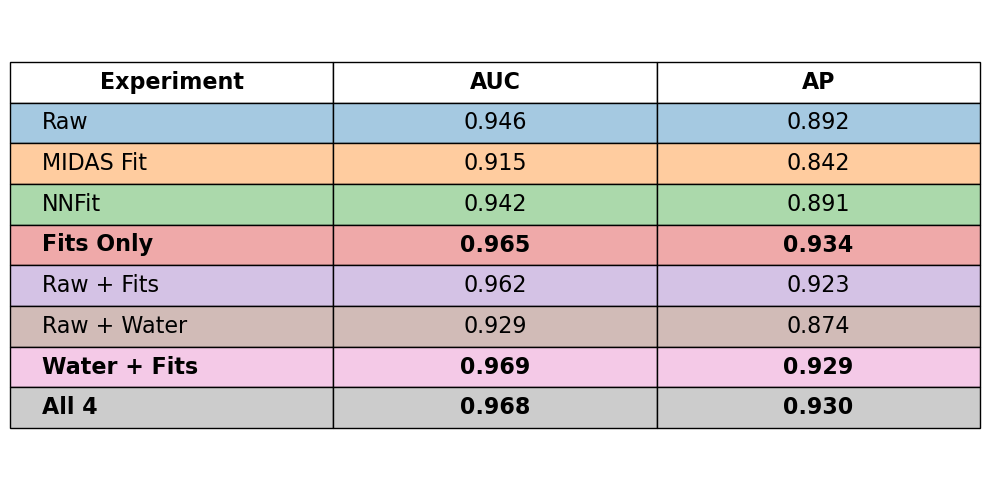

In [6]:
import matplotlib.colors as mcolors

# ── 3) Build table DataFrame and compute combined scores ───────────────────
rows = []
combined_scores = []
for key in exp_order:
    d = metrics_data[key]
    auc = d["auc"]
    ap = d["average_precision"]
    rows.append([label_map[key], f"{auc:.3f}", f"{ap:.3f}"])
    combined_scores.append(auc + ap)

df = pd.DataFrame(rows, columns=["Experiment", "AUC", "AP"])

# ── 4) Identify top-3 indices by combined score ────────────────────────────
combined_scores = np.array(combined_scores)
# indices of top 3 highest combined scores
top3_indices = np.argsort(combined_scores)[-3:]

# ── 5) Create matplotlib table with bold for top 3 ─────────────────────────
fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 1))
ax.axis("off")
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    loc="center"
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# iterate cells and style
for (row, col), cell in table.get_celld().items():
    # header row
    if row == 0:
        cell.get_text().set_fontweight('bold')
        cell.set_text_props(ha='center')
        continue

    # pick the color for this experiment
    base = colors[(row-1) % len(colors)]
    rgba = mcolors.to_rgba(base)

    # lighten it (70% white, 30% base) so the text stays readable
    light = (
        0.6 + 0.4*rgba[0],
        0.6 + 0.4*rgba[1],
        0.6 + 0.4*rgba[2],
        rgba[3]
    )
    cell.set_facecolor(light)

    # left‐align the experiment name column
    if col == 0:
        cell.get_text().set_ha('left')
        cell.set_text_props(x=0.01)

    # bold the top‐3 rows
    if (row-1) in top3_indices:
        cell.get_text().set_fontweight('bold')

# final tweaks
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1, 2)
fig.tight_layout()
plt.show()

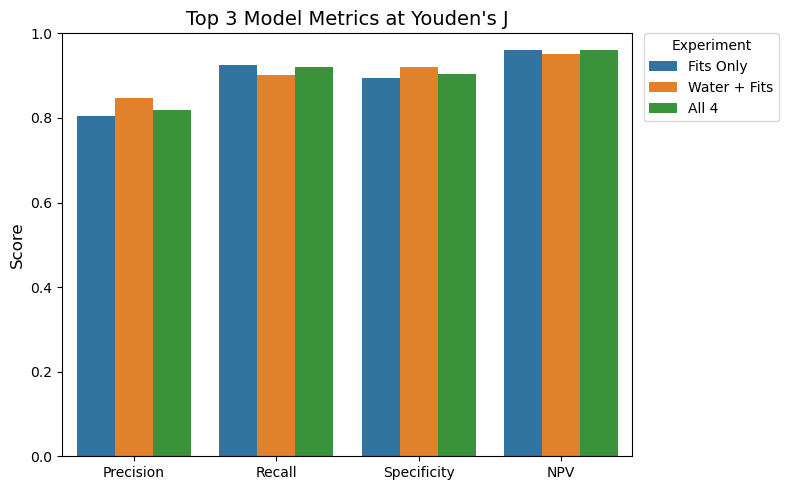

In [7]:
output_dir = base_dir / "results"
model_dir  = base_dir / "models"

with open(output_dir / "ensemble_metrics_data.pkl","rb") as f:
    metrics_data = pickle.load(f)

# We fix the top3 and their display order
top3_keys = ['fits_combined', 'fits+water', 'all_four']

# ── 4) Compute thresholded metrics at Youden's J ───────────────────────────
rows = []
for key in top3_keys:
    d = metrics_data[key]
    thr = d["youden_thr"]
    y_prob = d["y_prob"]
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    rows.append({
        "Experiment":  label_map[key],
        "Precision":   precision_score(y_te, y_pred),
        "Recall":      recall_score(y_te, y_pred),
        "Specificity": tn / (tn + fp),
        "NPV":         tn / (tn + fn)
    })

metrics_df = pd.DataFrame(rows)

# ── 5) Melt for grouped bar chart ───────────────────────────────────────────
df_melt = metrics_df.melt(
    id_vars="Experiment",
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="Metric", y="Score", hue="Experiment",
    data=df_melt, palette="tab10",
    hue_order=[label_map[k] for k in top3_keys]
)
ax.set_ylim(0, 1)
ax.set_title("Top 3 Model Metrics at Youden's J", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Score", fontsize=12)

# Move legend outside to the right
ax.legend(
    title="Experiment",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout()
plt.show()

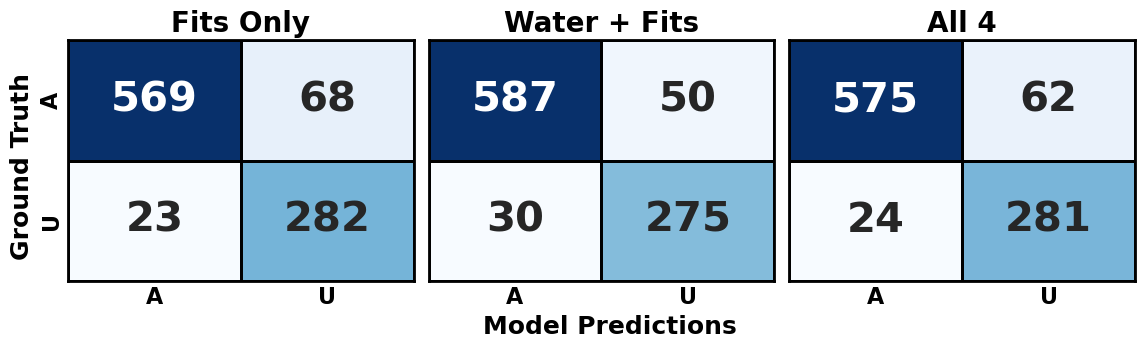

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, key in zip(axes, top3_keys):
    d      = metrics_data[key]
    thr    = d["youden_thr"]
    y_pred = (d["y_prob"] >= thr).astype(int)
    cm     = confusion_matrix(y_te, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        linewidths=1,           # draw borders between cells
        linecolor='black',      # cell border color
        annot_kws={"size": 30, "weight": "bold"},
        xticklabels=["A","U"],
        yticklabels=["A","U"],
        ax=ax
    )

    # Remove default tick lines, set tick labels
    ax.tick_params(axis='both', which='both', length=0, labelsize=16)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

    # Turn on the outer axes spines for a full border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # Remove individual axis titles
    ax.set_title(label_map[key], fontsize=20, fontweight="bold")
    ax.set_xlabel("")  # we'll add globals later
    ax.set_ylabel("")

# Global titles and labels
#fig.suptitle(f"Confusion Matrices at Threshold ({thr:.2f})",
#             fontsize=16, fontweight="bold")

# Global axis labels
fig.supxlabel("Model Predictions", fontsize=18, fontweight="bold", y=0.09, x = 0.55)
fig.supylabel("Ground Truth",      fontsize=18, fontweight="bold", x=0.05, y = 0.52)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig('confusionmatrix', dpi = 600)
plt.show()


In [2]:
file_path = r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\spectral_train_20250423_1640.pkl"

# 1) Generic pickle load
with open(file_path, 'rb') as f:
    obj = pickle.load(f)

# 2) Count entries
if hasattr(obj, '__len__'):
    print(f'Total entries: {len(obj)}')
elif hasattr(obj, 'shape'):  # e.g. numpy array, pandas DataFrame
    rows, cols = obj.shape
    print(f'Shape: {rows} rows × {cols} columns')
else:
    print(f'Loaded object of type {type(obj)}, no obvious length/shape attribute.')

Total entries: 4522


In [3]:
# length:
print(f"Total entries: {len(obj)}")
# peek at the first 3 entries:
from pprint import pprint
pprint(obj[:1])

Total entries: 4522
[{'assigned_raters': ['Hyunsuk Shim', 'Brent Weinberg', 'Sulaiman Sheriff'],
  'consensus_rating': 'Acceptable',
  'midas_fit': array([ 5.43166771e+01,  7.13252869e+01,  7.32909546e+01,  7.50589142e+01,
        7.67425842e+01,  7.84563675e+01,  8.03455734e+01,  8.24994278e+01,
        8.49670792e+01,  8.77721252e+01,  9.08652191e+01,  9.41719284e+01,
        9.76467667e+01,  1.01251053e+02,  1.04955513e+02,  1.08728760e+02,
        1.12502769e+02,  1.16219315e+02,  1.19852783e+02,  1.23349358e+02,
        1.26636078e+02,  1.29604034e+02,  1.32078537e+02,  1.33950058e+02,
        1.35221237e+02,  1.35930130e+02,  1.36172531e+02,  1.36121140e+02,
        1.35940521e+02,  1.35832642e+02,  1.36082733e+02,  1.36905121e+02,
        1.38411194e+02,  1.40675110e+02,  1.43664917e+02,  1.47248413e+02,
        1.51328079e+02,  1.55775726e+02,  1.60413300e+02,  1.65155670e+02,
        1.69951416e+02,  1.74791885e+02,  1.79777985e+02,  1.84993286e+02,
        1.90496429e+02,  1.

In [6]:
import pickle

file_path = r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\spectral_train_20250423_1640.pkl"

# Load the pickle
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Gather unique subject_ids
subject_ids = {entry.get('subject_id') for entry in data if 'subject_id' in entry}

# Report
print(f"Found {len(subject_ids)} unique subject_id(s):")
for sid in sorted(subject_ids):
    print(sid)


Found 52 unique subject_id(s):
DOSEESC_EM02
DOSEESC_EM03
DOSEESC_EM04
DOSEESC_EM05
DOSEESC_EM07
DOSEESC_EM08
DOSEESC_EM09
DOSEESC_EM10
DOSEESC_EM11
DOSEESC_EM12
DOSEESC_EM13
DOSEESC_EM15
DOSEESC_JH01
DOSEESC_JH02
DOSEESC_JH03
DOSEESC_JH04
DOSEESC_JH07
DOSEESC_JH10
DOSEESC_UM02
DOSEESC_UM03
DOSEESC_UM04
DOSEESC_UM05
DOSEESC_UM06
DOSEESC_UM07
DOSEESC_UM08
DOSEESC_UM09
DOSEESC_UM09_70
DOSEESC_UM13
DOSEESC_UM14
DOSEESC_UM15
DOSEESC_UM16
DOSEESC_UM18
DOSEESC_UM20
DOSEESC_UM21
rGBM_001_02_27_2023
rGBM_001_04_21_2023
rGBM_001_06_30_2023
rGBM_001_08_30_2023
rGBM_002_04_28_2023
rGBM_003_04_24_2023
rGBM_005_08_18_2023
rGBM_006_04_03_2023
rGBM_006_05_24_2023
rGBM_006_08_01_2023
rGBM_007_05_30_2023
wholeGBM_001_05_26_2023
wholeGBM_001_07_26_2023
wholeGBM_002_04_13_2023
wholeGBM_003_06_14_2023
wholeGBM_004_03_10_2023
wholeGBM_004_04_19_2023
wholeGBM_004_07_03_2023
